# 2.3 Clustering!

In [8]:
import pandas as pd
import sklearn.preprocessing
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from collections import Counter
from sklearn.cluster import KMeans


After having installed the desired packages and libraries we define our datas as the three principal components that mostly represent out data and we call them 'df'. We then save the datas as a csv for future needs.

In [10]:
df=pd.read_csv('reduced_features.csv')
df=df.iloc[:, :3]

In [ ]:
df.to_csv('red.csv', index=False)

### Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

To perform this part I used PySPark, which uses MapReduce, but I wasn't able to perform a proper K-Means clustering algorithm using MapReduce due to some technical problems with RDD.

Let's start by importing the desired packages

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from tqdm import tqdm

This first funtion is used to perform kmeans clustering. What it does is converting input DataFrame to feature vectors, performing k-means clustering, and getting cluster centroids.


In [2]:
def kmeans_prova(data, k, max_iterations=10):
    assembler = VectorAssembler(inputCols=data.columns, outputCol="features")
    assembled_data = assembler.transform(data)

    kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=k, maxIter=max_iterations)
    model = kmeans.fit(assembled_data)
    centroids = model.clusterCenters()

    return centroids, assembled_data, model

The following elbow_method is a function that implements and plots the elbow method and the silhouette score to find the optimal k number of clusters

In [3]:
def elbow_method(data, k_values):
    em = {} 
    silhouette_scores = {}

    for k in tqdm(k_values):
        centroids, assembled_data, model = kmeans_prova(data, k)
        predictions = model.transform(assembled_data)
        em[k] = model.summary.trainingCost

        # Evaluate clustering by computing Silhouette score
        evaluator = ClusteringEvaluator()
        silhouette_score = evaluator.evaluate(predictions)
        silhouette_scores[k] = silhouette_score

    # Plot the Elbow curve
    plt.plot(list(em.keys()), list(em.values()), marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.show()

    # Plot Silhouette Score
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
    plt.title('Silhouette Score for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.show()

### Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

After having created the function we run and see the result:

100%|████████████████████████████████████████████| 9/9 [01:07<00:00,  7.45s/it]


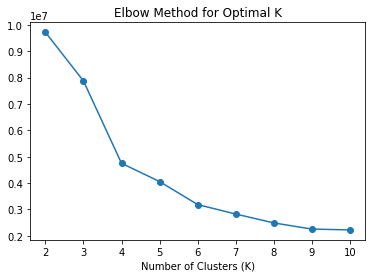

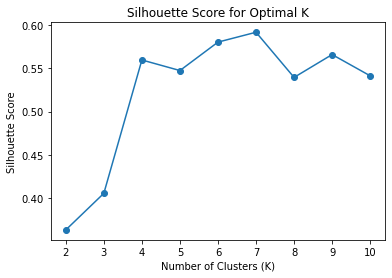

In [5]:
if __name__ == "__main__":
    spark = SparkSession.builder.appName("KMeans").getOrCreate()

    data = spark.read.csv("red.csv", header=True, inferSchema=True)

    k_values = range(2, 11)

    # Elbow Method and Silhouette Score
    elbow_method(data, k_values)

    spark.stop()

From the elbow method we don't observe a proper angle but more of a soft slope. By the way, the optimal k value would seem to be at 4 clusters

From the silhouette score the maximum is 7, but 4 is a local maximum. There is a difference between the two results.

### Implement K-means++ from scratch and explain the differences with the results you got earlier.


We now run the K-means++ algortithm

In [11]:
X = df.values
em={}
for k in tqdm(range(2,11)):
    model=KMeans(n_clusters=k,init='k-means++')
    model.fit(X)
    em[k]=model.inertia_

100%|████████████████████████████████████████████| 9/9 [01:18<00:00,  8.71s/it]


Map-reduce k-means and k-means++ differ primarily in their methods for selecting the initial centroids. The first onr uses random sampling, while the second one  selects centroids to maximize inter-cluster distances. This leads to well-separated clusters, making point assignments more accurate and reducing instances of misassignment.

Now we implement the elbow method to graphically display the optimal number of clusters

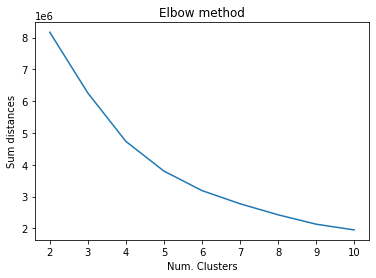

In [13]:
plt.figure()
plt.plot(list(em.keys()), list(em.values()))
plt.xlabel('Num. Clusters')
plt.ylabel('Sum distances')
plt.title('Elbow method')
plt.show()

From this graph the optimal number of cluster seems to be 4 or 5, it's still not clear

The second metric we implement is the Davies Bouldin score

100%|████████████████████████████████████████████| 9/9 [01:25<00:00,  9.54s/it]


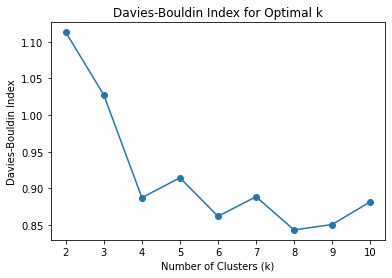

The optimal k number suggested by this index is: 8


In [14]:
from sklearn.metrics import davies_bouldin_score


dbi_scores = []

for k in tqdm(range(2, 11)):
    model = KMeans(n_clusters=k, init='k-means++')
    model.fit(X)
    dbi_score = davies_bouldin_score(X, model.labels_)
    dbi_scores.append(dbi_score)

optimal_k_dbi = np.argmin(dbi_scores) + 2  # +2 perché abbiamo iniziato da k=2

plt.plot(range(2, 11), dbi_scores, marker='o')
plt.title('Davies-Bouldin Index for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.show()

print(f'The optimal k number suggested by this index is: {optimal_k_dbi}')


### Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

To identify an optimal number of clusters we usd the elbow method and the Davies-Bouldin Index for Optimal k. 
From the elbwow method the change of slope seems to appear somewehere between 4 and 5, so we applied also the Davies-Bouldin Index, that suggests us a value of 8 clusters. Since we can observe a local minimum at 4 and 6 cluster, and given the result of the elbow method, we choose 4 as the number of clusters.

### Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

Chat GPT proposed different algorithms and implememtations but most of them were not suitable for our data. At the end, we selected this one, the BIRCH.

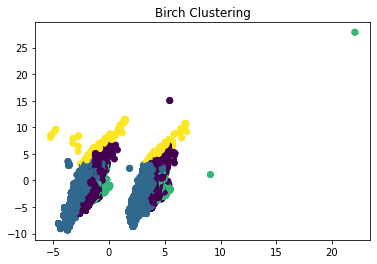

In [15]:
from sklearn.cluster import Birch
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

birch = Birch(n_clusters=4)

labels = birch.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('Birch Clustering')
plt.show()


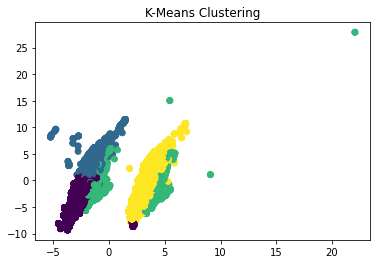

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, init='k-means++')

# Fit the model and get cluster labels
labels = kmeans.fit_predict(X)

# Plot the clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('K-Means Clustering')
plt.show()


From graphically analyzing the results, the BIRCH method seems to focus on the similarities of the elements in the clusters, while kmeans++ created more defined clusters. From this point of view, we can say kmeans++ performed better.


# 2.4 Analysing your results! --



#### You are often encouraged to explain the main characteristics that your clusters have. The latter is called the Characterizing Clusters step. Thus, follow the next steps to do it:

#### Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.

In [17]:
famd_data= pd.read_csv('famd_features.csv')

Let's add to the dataset a column that represents the cluster each observation belogs to

In [20]:
model = KMeans(n_clusters=4, init='k-means++')
model.fit(X) 

famd_data['cluster'] = model.labels_
new_data=famd_data

We choose the features average_click_duration, and average_release_year, that represent the behavior of the users and their preferencies.

#### With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

#### Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.

In [21]:
selected_variables = ['average_click_duration', 'average_release_year']

for variable in selected_variables:
    new_data[f'{variable}_Category'] = pd.qcut(new_data[variable], q=[0, 0.25, 0.5, 0.75, 1], labels=['Q1', 'Q2', 'Q3', 'Q4'])



In [22]:
for variable in selected_variables:
    pivot_table = pd.pivot_table(new_data, values=variable, index='cluster', columns=f'{variable}_Category', aggfunc='count', fill_value=0)

    pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
    print(f'\n{variable} Pivot Table:')
    print(pivot_table_percentage)



average_click_duration Pivot Table:
average_click_duration_Category         Q1         Q2         Q3         Q4
cluster                                                                    
0                                25.632567  26.492203  24.321682  23.553548
1                                34.719472  20.995217  19.804068  24.481242
2                                32.864465  22.270913  21.689882  23.174740
3                                15.994293  26.992682  29.924793  27.088232

average_release_year Pivot Table:
average_release_year_Category         Q1         Q2         Q3         Q4
cluster                                                                  
0                              22.616376  24.963640  31.198771  21.221213
1                              18.033092  20.390964  34.147361  27.428582
2                              74.059003  10.480085   9.155646   6.305266
3                              24.843025  28.473488  30.855195  15.828292


#### Interpret the results for each pivot table.


For avreage click duration, in the first cluster the users are evenly distributed, while the second and third cluster represents more the users with small values of average click duration. The fouth cluster represents more all the users but the ones with small values. 

For the average release year of the movie, we can say that people that prefer newer movies are in the second cluster, which is pretty similar to the first. The third cluster represent people that prefer really old movies, while the fourh one represent mostly people that like movies that arenot old but not even the last movies out.

### Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?). Comment on the results obtained.

In [24]:
from sklearn.metrics import calinski_harabasz_score

model = KMeans(n_clusters=4, init='k-means++')
model.fit(X)

# Evaluate Calinski-Harabasz Index
calinski_harabasz_score_value = calinski_harabasz_score(X, model.labels_)
print(f'Calinski-Harabasz Index: {calinski_harabasz_score_value}')

Calinski-Harabasz Index: 356952.4939810794


As evaluation metric we used the Calinski-Harabasz Index, which gives us a value of 356952.49

100%|████████████████████████████████████████████| 9/9 [00:58<00:00,  6.48s/it]


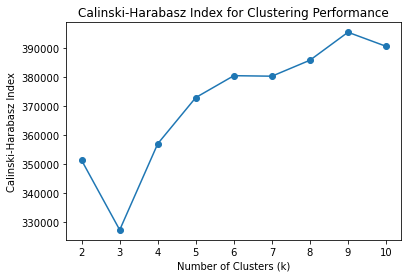

In [25]:
calinski_harabasz_scores = []

for k in tqdm(range(2, 11)):
    model = KMeans(n_clusters=k, init='k-means++', random_state=0)
    model.fit(X)

    # Calinski-Harabasz Index
    calinski_harabasz_score_value = calinski_harabasz_score(X, model.labels_)
    calinski_harabasz_scores.append(calinski_harabasz_score_value)

plt.plot(range(2, 11), calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Index for Clustering Performance')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.show()

Plotting the Calinski-Harabasz score for all the number of cluster we see that the maximun is at 9 cluster. The value of 4 does not seem the best. The difference between all the metrics we used to find an optimal values of k suggests us that our data is very complicated and not easy to clusterize, so it's important not only to follow the metrics but also to have an understanding of our goals and what we need to do with our dataset in order to select the best k number.